## 0. &nbsp; Import required libraries

---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from utils.VAE import VariationalAutoencoder
from utils.loader import load_model, ImageLabelLoader

## 1. &nbsp; Setups
---


### VAE and DFC-VAE 


<center><img src="./results/fig.png"/></center>

<br>

### VGG-19 Architecture:


<center><img src="./results/vgg16.png"/></center>

<br>

### Loss function in DFC-VAE:


$$
L_{total} = \alpha L_{kl} + \beta \sum_{i}^{l} L^i_{rec}
$$

Where $L^i_{rec}$ is obtained from pretrained VGG-19 CNN, and $\alpha$ and $\beta$ are hyperparameters.

<br>


### Consider the following VAE models:


- Plain-VAE
- DFC-VAE-123 
- DFC-VAE-345

In [4]:
# specify the path of folder
DATA_FOLDER = './data'
IMAGE_FOLDER = './data/celeb'
PVAE_RUN_FOLDER = './run/Plain-VAE/optimal'
DFCVAE_123_FOLDER = './run/DFC-VAE-123/alpha03_full' # alpha = 0.03
DFCVAE_345_FOLDER = './run/DFC-VAE-345/alpha3' # alpha = 0.3

# Input dimension
INPUT_DIM = (128, 128, 3)

# Attribute of images
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

# Create an image loader
imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

## 2. &nbsp; Load pre-trained models: 

---


In [5]:
PVAE = load_model(VariationalAutoencoder, PVAE_RUN_FOLDER)
DFC_VAE_123 = load_model(VariationalAutoencoder, DFCVAE_123_FOLDER)
DFC_VAE_345 = load_model(VariationalAutoencoder, DFCVAE_345_FOLDER)

Enter plain-VAE mode building.
Enter DFC-VAE-123 mode building.
Enter DFC-VAE-345 mode building.


## 3. &nbsp; Reconstructions

---

In [14]:
# Specify the number of images we want to test
n_img = 12

# Create data flow
data_flow_generic = imageLoader.build(att, n_img)

Found 202599 validated image filenames.


In [39]:
# Make predictions (reconstructions)

# 32 batch data flow
imgs_batch = next(data_flow_generic)
imgs = imgs_batch[0]

# Model 1: PVAE
z_sample_PVAE = PVAE.encoder.predict(imgs)
reconst_imgs_PVAE = PVAE.decoder.predict(z_sample_PVAE)

# Model 2: DFC-VAE-123
z_sample_DVAE_123 = DFC_VAE_123.encoder.predict(imgs)
reconst_imgs_DVAE_123 = DFC_VAE_123.decoder.predict(z_sample_DVAE_123)

# Model 2: DFC-VAE-345
z_sample_DVAE_345 = DFC_VAE_345.encoder.predict(imgs)
reconst_imgs_DVAE_345 = DFC_VAE_345.decoder.predict(z_sample_DVAE_345)

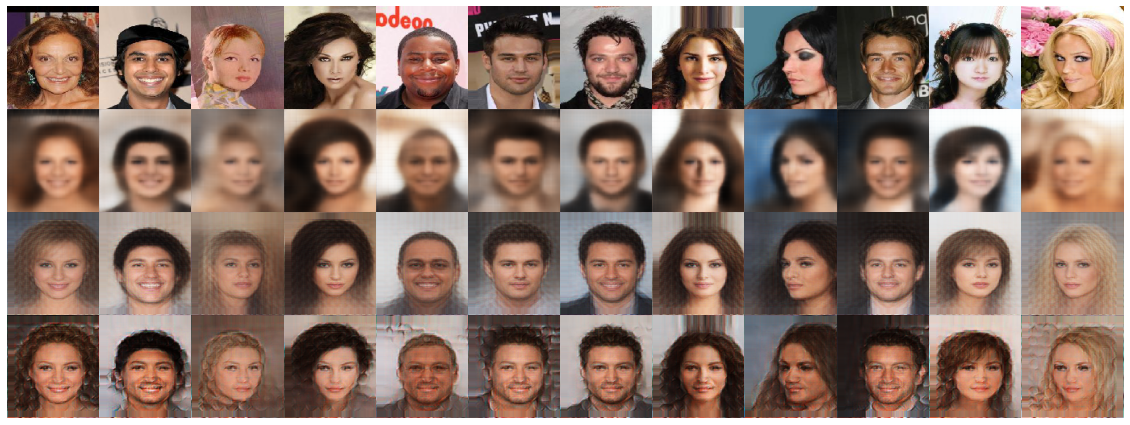

In [35]:
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace=-0.18, wspace=-0.1)

for i in range(n_img):
    img = imgs[i].squeeze()
    sub1 = fig.add_subplot(4, n_img, i+1)
    sub1.axis('off')
    sub1.imshow(img)

for i in range(n_img):
    img = reconst_imgs_PVAE[i].squeeze()
    sub1 = fig.add_subplot(4, n_img, i+n_img+1)
    sub1.axis('off')
    sub1.imshow(img)
    
for i in range(n_img):
    img = reconst_imgs_DVAE_123[i].squeeze()
    sub2 = fig.add_subplot(4, n_img, i+2*n_img+1)
    sub2.axis('off')
    sub2.imshow(img)
    
for i in range(n_img):
    img = reconst_imgs_DVAE_345[i].squeeze()
    sub3 = fig.add_subplot(4, n_img, i+3*n_img+1)
    sub3.axis('off')
    sub3.imshow(img)
    
fig.savefig("./results/reconstruction.png", dpi=300)

## 4. &nbsp; Generate fake faces

---


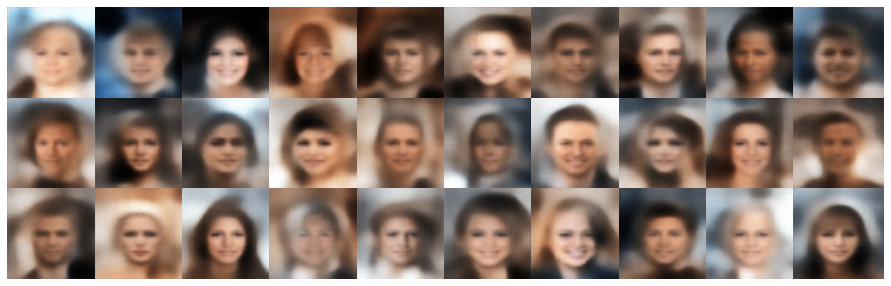

In [84]:
n_to_show = 30

np.random.seed(seed=123)
znew = np.random.normal(size = (n_to_show, PVAE.z_dim))  # 1

reconst = PVAE.decoder.predict(np.array(znew)) # alpha = 0.03

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0, wspace=-0.6)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])  # 3
    ax.axis('off')

fig.savefig("./results/fake_face_PVAE.png", dpi=300)
plt.show()

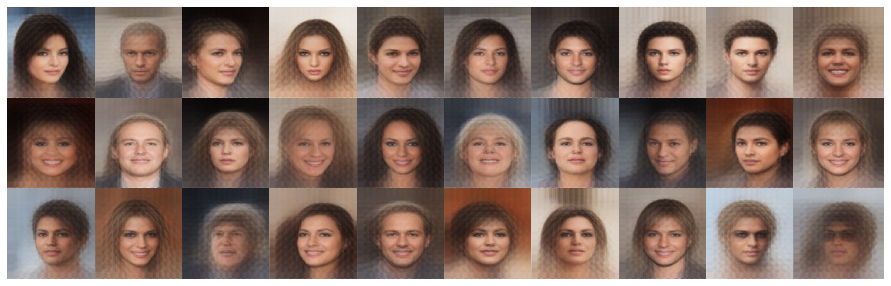

In [40]:
n_to_show = 30

np.random.seed(seed=123)
znew = np.random.normal(size = (n_to_show, DFC_VAE_123.z_dim))  # 1

reconst = DFC_VAE_123.decoder.predict(np.array(znew)) # alpha = 0.03

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0, wspace=-0.6)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])  # 3
    ax.axis('off')

fig.savefig("./results/fake_face_123.png", dpi=300)
plt.show()

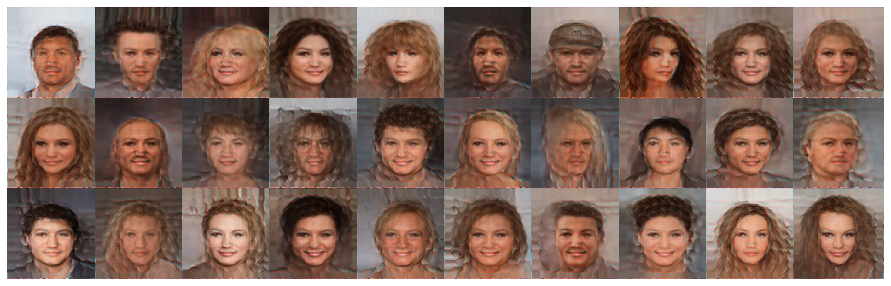

In [37]:
n_to_show = 30

np.random.seed(seed=123)
znew = np.random.normal(size = (n_to_show, DFC_VAE_345.z_dim))  # 1

reconst = DFC_VAE_345.decoder.predict(np.array(znew)) # alpha = 0.03

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0, wspace=-0.6)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])  # 3
    ax.axis('off')

fig.savefig("./results/fake_face_345.png", dpi=300)
plt.show()

## 5. &nbsp; Latent Space Arithmetic

---

One benefit of mapping images into a lower-dimensional space is that we can perform arithmetic on vectors in this latent space that has a visual analogue when decoded back into the original image domain.


More specifically, we can perfrom vector arithmetic in latent space

$$
Z_{\mbox{new}} = Z + \alpha  u
$$

where $Z$ is latent variables, $\alpha$ is a factor that determines how much of the feature vector and $u$ is a feature vector.





In [62]:
def get_vector_from_label(label, batch_size):   

    data_flow_label = imageLoader.build(att, batch_size, label = label)   
     
     
    # initiating vectors
    origin = np.zeros(shape = DFC_VAE_123.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = DFC_VAE_123.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = DFC_VAE_123.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = DFC_VAE_123.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = DFC_VAE_123.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = DFC_VAE_123.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):       
       
        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = DFC_VAE_123.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        # this is for adding attributes
        if len(z_POS) > 0:           
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        # for subtracting attributes
        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist       
       

        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:           
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector \n')
            break

    return current_vector  

In [107]:
def add_vector_to_images(feature_vec):   

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = DFC_VAE_123.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 8))
    fig.subplots_adjust(hspace=0, wspace=-0.65)

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = DFC_VAE_123.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

In [83]:
# Respective attribute vectors
BATCH_SIZE = 500

smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

In [120]:
import pickle 

with  open('results/arithmetic.obj', 'wb') as f:
    pickle.dump(
        [ attractive_vec, mouth_open_vec, smiling_vec, lipstick_vec, young_vec, male_vec
         , eyeglasses_vec, blonde_vec ] ,
        f
    )

Smile vector


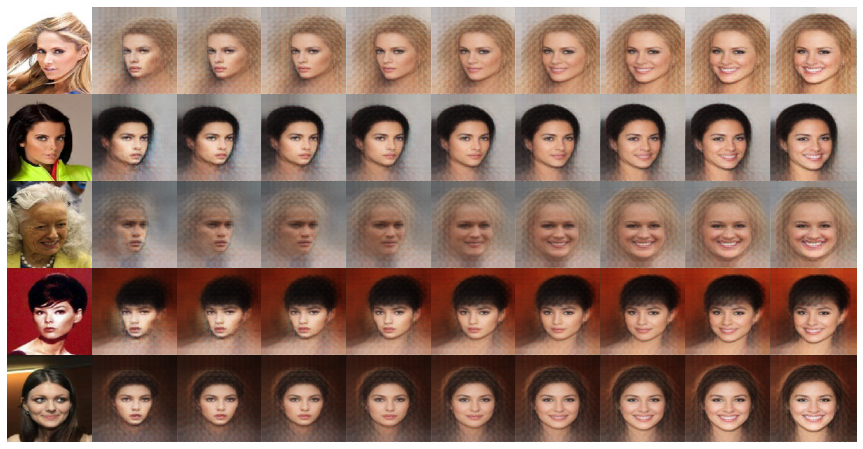

In [119]:
print("Smile vector")
add_vector_to_images(smiling_vec)

Male Vector


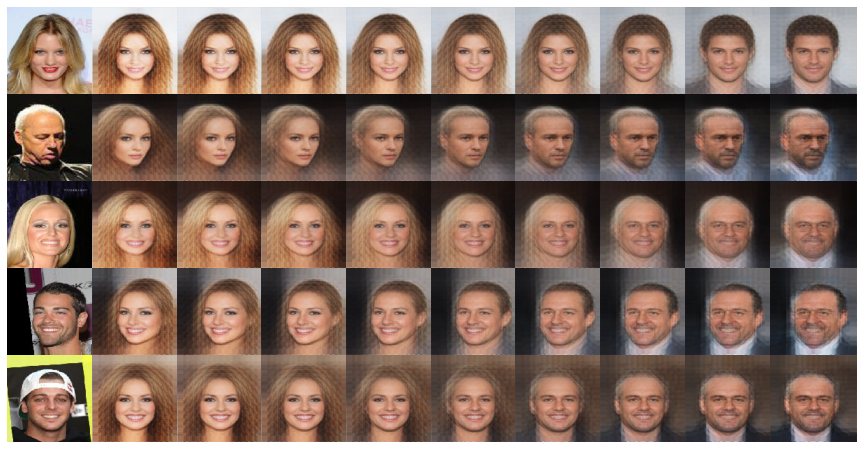

In [124]:
print('Male Vector')
add_vector_to_images(male_vec)

Eyeglasses Vector


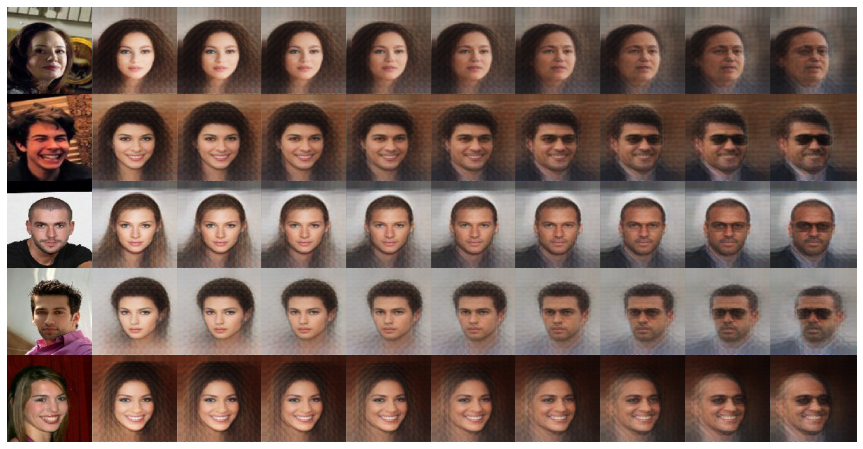

In [121]:
print('Sun glasses Vector')
add_vector_to_images(eyeglasses_vec)

Blond Vector


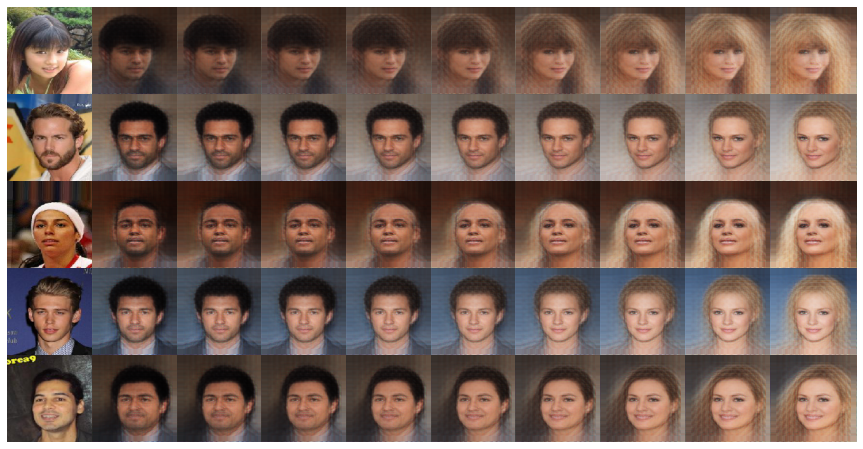

In [122]:
print('Blond Vector')
add_vector_to_images(blonde_vec)

## 6.&nbsp; Interpolated faces

Imagine two points in the latent space, A and B, that represent two images. If you started at point A and walked toward point B in a straight line, decoding each point on the line as you went, you would see a gradual transition from the starting face to the end face.

$$
Z_{\mbox{new}} = Z_A (1-\alpha) + Z_B (\alpha)
$$


where $Z_A$ is the latent space point of $A$, $Z_B$ is the latent space point of B,  $\alpha$ is a number between 0 and 1 that determines how far along the line we are, away from point A.



In [164]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.15)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = DFC_VAE_123.encoder.predict(example_images)


    fig = plt.figure(figsize=(16, 10))
    fig.subplots_adjust(hspace=0, wspace=0)

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')       
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = DFC_VAE_123.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')       
    sub.imshow(img)

    plt.show()

Found 2 validated image filenames.


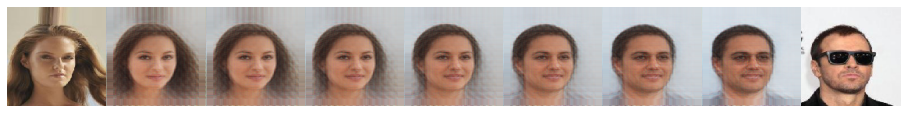

In [165]:
# Glasses
start_image_file = '000238.jpg'
end_image_file = '000193.jpg'
morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


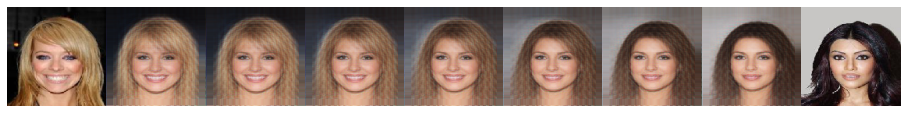

In [166]:
# Women
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'
morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


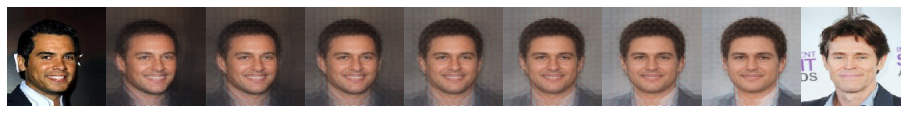

In [167]:
# Men
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'
morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


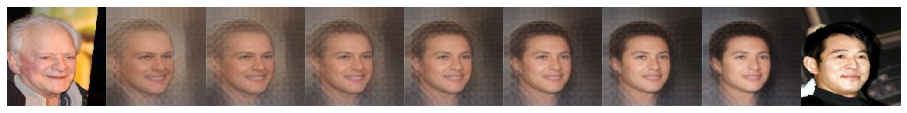

In [168]:
# Asian, american
start_image_file = '004230.jpg'
end_image_file = '004723.jpg'
morph_faces(start_image_file, end_image_file)